In [32]:
import os
import pandas as pd
from config import config
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [48]:
def create_features(data):
    if data.index.dtype != 'datetime64[ns]':
        data['DateTime'] = data['Year'].astype(str) + '-' + data['Month'].astype(str) + '-' + data['Day'].astype(str) + ' ' + data['ObsTime'].astype(str) + ':00:00'
        data['DateTime'] = pd.to_datetime(data['DateTime'])
        data.set_index('DateTime', inplace=True)

    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Day'] = data.index.day
    data['ObsTime'] = data.index.hour
    data['DayofYear'] = data.index.dayofyear
    data['Quarter'] = data.index.quarter
    data['WeekofYear'] = data.index.isocalendar().week.astype('int')
    data['Year_Avg'] = data['Temperature'].groupby(data.index.year, group_keys=False).apply(expand_mean).shift(1)
    data['Month_Avg'] = data['Temperature'].groupby([data.index.year, data.index.month], group_keys=False).apply(expand_mean).shift(1)
    data['Day_Avg'] = data['Temperature'].groupby([data.index.year, data.index.month, data.index.day], group_keys=False).apply(expand_mean).shift(1)
    data['24hr_Avg'] = data['Temperature'].rolling('24H').mean().shift(1)
    data['30d_Avg'] = data['Temperature'].rolling('30D').mean().shift(1)
    data['365d_Avg'] = data['Temperature'].rolling('365D').mean().shift(1)

    data.loc[data.index.hour == 0, 'Day_Avg'] = pd.NA
    data.loc[(data.index.hour == 0) & (data.index.day == 1), 'Month_Avg'] = pd.NA
    data.loc[(data.index.hour == 0) & (data.index.day == 1) & (data.index.month == 1), 'Year_Avg'] = pd.NA

    data.loc[data.index.date == data.index[0].date(), '24hr_Avg'] = pd.NA
    data.loc[(data.index.year == data.index[0].year) & (data.index.month == data.index[0].month), '30d_Avg'] = pd.NA
    data.loc[data.index.year == data.index[0].year, '365d_Avg'] = pd.NA

    data = add_lags(data)
    return data

def add_lags(data):
    target_map = data['Temperature'].to_dict()
    for year in range(config['years_of_lag']):
        data[f'{year + 1} Year lag'] = (data.index - pd.DateOffset(years=year + 1)).map(target_map)
    for day in range(3):
        data[f'{day+1} Day lag'] = (data.index - pd.DateOffset(days=day + 1)).map(target_map)
    return data

def expand_mean(data):
    return data.expanding(1).mean()

In [49]:
df = pd.read_csv(os.path.join(config['path'], 'test_file.csv'))
df = create_features(df)
df

,Year,Month,Day,ObsTime,StnPres,Temperature,RH,WS,WD,Precp,...,Day_Avg,24hr_Avg,30d_Avg,365d_Avg,1 Year lag,2 Year lag,3 Year lag,1 Day lag,2 Day lag,3 Day lag
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-11-01 01:00:00,2011,11,1,1,1000.4,21.3,80.0,0.7,312.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-01 02:00:00,2011,11,1,2,1000.0,21.1,81.0,1.1,308.0,0.0,...,21.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-01 03:00:00,2011,11,1,3,1000.0,21.4,80.0,1.4,322.0,0.0,...,21.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-01 04:00:00,2011,11,1,4,1000.0,22.3,77.0,0.9,45.0,0.0,...,21.266667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-01 05:00:00,2011,11,1,5,1000.1,21.6,81.0,1.0,317.0,0.0,...,21.525000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-19 19:00:00,2023,2,19,19,1002.2,17.3,75.0,2.5,346.0,0.0,...,18.889474,19.520833,16.830199,24.165617,14.6,16.2,16.0,23.9,16.2,15.3
2023-02-19 20:00:00,2023,2,19,20,1002.8,17.0,77.0,1.9,350.0,0.0,...,18.810000,19.245833,16.831481,24.165939,14.2,15.5,15.2,22.9,15.7,15.2
2023-02-19 21:00:00,2023,2,19,21,1003.2,16.9,78.0,2.5,351.0,0.0,...,18.723810,19.000000,16.832764,24.166273,13.7,15.2,14.9,22.8,15.7,15.1


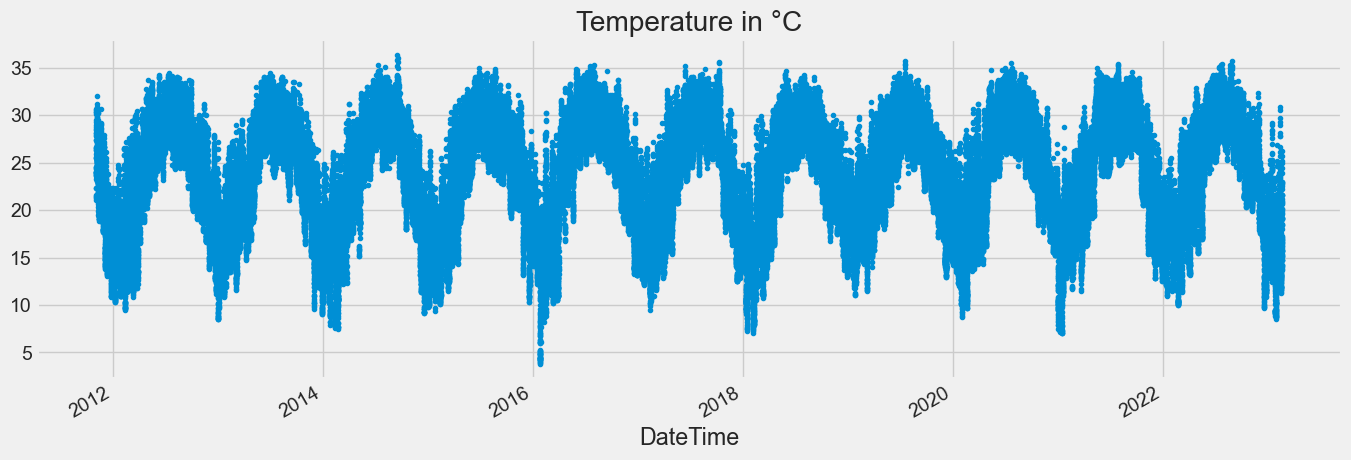

In [35]:
temp_data = df['Temperature']
temp_data.plot(style= '.',
               figsize=(15, 5),
               color=color_pal[0],
               title='Temperature in °C')
plt.show()
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

# Train data with Time Split

## Define Features and Target

In [51]:
FEATURES = ['Year', 'Month','Day', 'ObsTime', 'DayofYear', 'Quarter', 'WeekofYear', 'StnPres', 'RH', 'WS', 'WD',
            'Precp', 'Year_Avg', 'Month_Avg', 'Day_Avg', '24hr_Avg', '30d_Avg', '365d_Avg']
for i in range(config['years_of_lag']):
    FEATURES.append(f'{i+1} Year lag')
for i in range(3):
    FEATURES.append(f'{i+1} Day lag')
TARGET = ['Temperature']

In [37]:
from sklearn.metrics import mean_absolute_error
fold = 0
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    x_train = train[FEATURES]
    y_train = train[TARGET]

    x_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=90000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.001)
    reg.fit(x_train, y_train,
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=100)
    y_pred = reg.predict(x_test)
    score = mean_absolute_error(y_test, y_pred)
    scores.append(score)

[0]	validation_0-rmse:23.69430	validation_1-rmse:23.97717
[100]	validation_0-rmse:21.45699	validation_1-rmse:21.70531


KeyboardInterrupt: 

In [76]:
scores

[1.5054695179691053,
 1.559191183129402,
 1.4520376086343914,
 1.9767270718317598,
 1.4956344902352112]

# Retrain on all data

## Train / Test Split

In [52]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']

x_train = train[FEATURES]
y_train = train[TARGET]
x_test = test[FEATURES]
y_test = test[TARGET]
x_train

,Year,Month,Day,ObsTime,DayofYear,Quarter,WeekofYear,StnPres,RH,WS,...,Day_Avg,24hr_Avg,30d_Avg,365d_Avg,1 Year lag,2 Year lag,3 Year lag,1 Day lag,2 Day lag,3 Day lag
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-11-01 01:00:00,2011,11,1,1,305,4,44,1000.4,80.0,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-01 02:00:00,2011,11,1,2,305,4,44,1000.0,81.0,1.1,...,21.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-01 03:00:00,2011,11,1,3,305,4,44,1000.0,80.0,1.4,...,21.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-01 04:00:00,2011,11,1,4,305,4,44,1000.0,77.0,0.9,...,21.266667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-01 05:00:00,2011,11,1,5,305,4,44,1000.1,81.0,1.0,...,21.525000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,2021,12,31,19,365,4,52,1009.5,75.0,1.8,...,16.215789,15.900000,18.611667,24.126475,9.5,15.3,16.3,15.3,18.8,17.1
2021-12-31 20:00:00,2021,12,31,20,365,4,52,1010.2,78.0,2.5,...,16.220000,15.941667,18.612500,24.127259,9.5,15.3,16.3,15.0,18.0,16.8
2021-12-31 21:00:00,2021,12,31,21,365,4,52,1010.5,79.0,1.9,...,16.176190,15.954167,18.611944,24.127928,9.6,14.8,16.3,14.7,17.0,16.7


In [40]:
columns = ['max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'reg_alpha','MAE', 'RMSE', 'Run_Time']
col = pd.DataFrame(columns=columns)
replace = False
if replace:
    score_data = col
else:
    score_data = pd.read_csv(os.path.join(config['path'], 'score_data.csv'))
    score_data = pd.concat([score_data, col], ignore_index=True)
score_data.to_csv(os.path.join(config['path'], 'score_data.csv'), index=False)

In [53]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_absolute_error

depth = 6
rate = 0.001
sample = 1
colsample = 0.78
alpha = 800
# for i in range(7, 11):
#     sample = i/10
#     for j in range(7, 11):
#         colsample = j/10
print(f'Start training, max_depth = {depth}, learning_rate = {rate}, subsample = {sample}, colsample_bytree = {colsample}, reg_alpha = {alpha}\n')
start_time = time.time()
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=90000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',
                       max_depth=depth,
                       learning_rate=rate,
                       subsample=sample,
                       colsample_bytree=colsample,
                       reg_alpha=alpha)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
y_pred = reg.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
run_time = time.time() - start_time
row = {'max_depth': depth, 'learning_rate': rate, 'subsample': sample, 'colsample_bytree': colsample, 'reg_alpha': alpha,'MAE': mae, 'RMSE': rmse, 'Run_Time': run_time}
score_data = pd.read_csv(os.path.join(config['path'], 'score_data.csv'))
score_data = pd.concat([score_data, pd.DataFrame(row, index=[0])], ignore_index=True)
score_data.to_csv(os.path.join(config['path'], 'score_data.csv'), index=False)

score_data

Start training, max_depth = 6, learning_rate = 0.001, subsample = 1, colsample_bytree = 0.78, reg_alpha = 800

[0]	validation_0-rmse:23.91104	validation_1-rmse:23.48503
[100]	validation_0-rmse:21.65995	validation_1-rmse:21.27748
[200]	validation_0-rmse:19.62486	validation_1-rmse:19.28223
[300]	validation_0-rmse:17.78448	validation_1-rmse:17.47996
[400]	validation_0-rmse:16.12016	validation_1-rmse:15.84966
[500]	validation_0-rmse:14.61531	validation_1-rmse:14.37647
[600]	validation_0-rmse:13.25496	validation_1-rmse:13.04572
[700]	validation_0-rmse:12.02525	validation_1-rmse:11.84306
[800]	validation_0-rmse:10.91366	validation_1-rmse:10.75688
[900]	validation_0-rmse:9.90927	validation_1-rmse:9.77524
[1000]	validation_0-rmse:9.00178	validation_1-rmse:8.88752
[1100]	validation_0-rmse:8.18231	validation_1-rmse:8.08608
[1200]	validation_0-rmse:7.44211	validation_1-rmse:7.36352
[1300]	validation_0-rmse:6.77402	validation_1-rmse:6.71226
[1400]	validation_0-rmse:6.17148	validation_1-rmse:6.1251

,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,MAE,RMSE,Run_Time
0,6,0.001,1,0.78,800,0.684854,0.926592,963.795218
1,6,0.001,1,0.78,800,0.674018,0.914559,1472.234791


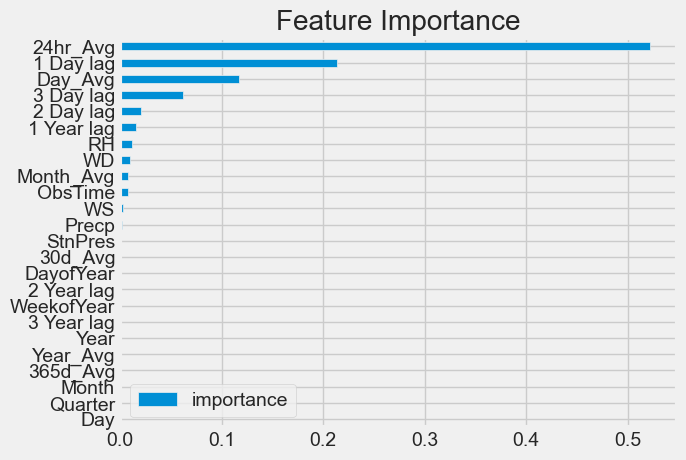

In [54]:
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                  index=FEATURES,
                                  columns=['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [55]:
test['Prediction'] = reg.predict(x_test)
predict = round(test.pop('Prediction'), 2)
test.insert(5, 'Prediction', predict)
test

C:\Users\itung\AppData\Local\Temp\ipykernel_24252\2439843139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = reg.predict(x_test)


,Year,Month,Day,ObsTime,StnPres,Prediction,Temperature,RH,WS,WD,...,Day_Avg,24hr_Avg,30d_Avg,365d_Avg,1 Year lag,2 Year lag,3 Year lag,1 Day lag,2 Day lag,3 Day lag
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,2022,1,1,0,1010.6,14.910000,15.2,80.0,0.3,29.0,...,NaN,16.016667,18.610278,24.129714,9.8,14.8,16.4,13.9,16.9,16.0
2022-01-01 01:00:00,2022,1,1,1,1010.5,14.900000,14.4,88.0,1.6,330.0,...,15.200000,16.070833,18.610278,24.130337,10.0,14.6,16.2,14.0,17.2,15.8
2022-01-01 02:00:00,2022,1,1,2,1010.5,14.610000,14.4,88.0,0.8,313.0,...,14.800000,16.087500,18.608333,24.130844,10.1,14.5,15.9,14.1,16.8,15.9
2022-01-01 03:00:00,2022,1,1,3,1010.0,14.320000,14.9,88.0,1.1,347.0,...,14.666667,16.100000,18.606528,24.131339,10.1,14.6,15.7,13.9,16.1,15.9
2022-01-01 04:00:00,2022,1,1,4,1010.0,14.260000,14.9,89.0,0.5,332.0,...,14.725000,16.141667,18.605833,24.131893,10.2,14.6,15.5,13.8,16.2,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-19 19:00:00,2023,2,19,19,1002.2,17.709999,17.3,75.0,2.5,346.0,...,18.889474,19.520833,16.830199,24.165617,14.6,16.2,16.0,23.9,16.2,15.3
2023-02-19 20:00:00,2023,2,19,20,1002.8,17.379999,17.0,77.0,1.9,350.0,...,18.810000,19.245833,16.831481,24.165939,14.2,15.5,15.2,22.9,15.7,15.2
2023-02-19 21:00:00,2023,2,19,21,1003.2,16.740000,16.9,78.0,2.5,351.0,...,18.723810,19.000000,16.832764,24.166273,13.7,15.2,14.9,22.8,15.7,15.1


## retrain All Data

In [ ]:
x_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=90000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=1)
reg.fit(x_all, y_all,
        eval_set=[(x_all, y_all)],
        verbose=100)

In [ ]:
df.index.max()
# creating future dataframe
future = pd.date_range('2023-02-20', '2023-12-31', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future

In [ ]:
df_and_future = create_features(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features['WeekofYear'] = future_w_features['WeekofYear'].astype('int')


# predict the future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[Future_FEATURES])

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1, lw=1,
                               title='Future Predictions')

In [ ]:
future_w_features.to_csv(os.path.join(config['path'], 'First_Prediction.csv'), index=False)
future_w_features

# Saving the Model

In [56]:
model = 'XGBoost'
reg.save_model(f'{model}_{depth}_{rate}_{sample}_{colsample}_{alpha}_1day_prediction.json')

# Load the Model

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

# plotting the data

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Temperature'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold+1}')
    test['Temperature'].plot(ax=axs[fold],
                             label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()